In [ ]:
print("✅ Installing required libraries...")
!pip install transformers datasets torch scikit-learn gdown -q

# ✅ Download the dataset from Google Drive
print("\n✅ Downloading dataset...")
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Using device: {device}")

# ✅ Dataset path
DATASET_PATH = '/content/drive/My Drive/code_plagiarism_dataset_final.csv'
print(f"✅ Dataset path set to: {DATASET_PATH}")


✅ Installing required libraries...

✅ Downloading dataset...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Using device: cuda
✅ Dataset path set to: /content/drive/My Drive/code_plagiarism_dataset_final.csv


In [ ]:
print("✅ Loading dataset from Google Drive...")
df = pd.read_csv(DATASET_PATH).dropna()

# Split data (80% train, 10% val, 10% test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print("\nDataset split successfully:")
print(f"🔹 Training set size:   {len(train_df)} pairs")
print(f"🔹 Validation set size: {len(val_df)} pairs")
print(f"🔹 Test set size:       {len(test_df)} pairs")

from datasets import Dataset as HFDataset
train_dataset = HFDataset.from_pandas(train_df)
val_dataset = HFDataset.from_pandas(val_df)
test_dataset = HFDataset.from_pandas(test_df)

print("\n✅ Converted to Hugging Face Dataset objects.")


✅ Loading dataset from Google Drive...

Dataset split successfully:
🔹 Training set size:   8000 pairs
🔹 Validation set size: 1000 pairs
🔹 Test set size:       1000 pairs

✅ Converted to Hugging Face Dataset objects.


In [ ]:
print("✅ Initializing CodeBERT tokenizer...")
MODEL_NAME = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class PlagiarismDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        pair = self.dataset[idx]
        code1 = pair['code1']
        code2 = pair['code2']
        label = pair['label']

        inputs1 = self.tokenizer(code1, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_length)
        inputs2 = self.tokenizer(code2, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_length)

        return {
            'input_ids1': inputs1['input_ids'].squeeze(0),
            'attention_mask1': inputs1['attention_mask'].squeeze(0),
            'input_ids2': inputs2['input_ids'].squeeze(0),
            'attention_mask2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(PlagiarismDataset(train_dataset, tokenizer), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(PlagiarismDataset(val_dataset, tokenizer), batch_size=BATCH_SIZE)
test_loader = DataLoader(PlagiarismDataset(test_dataset, tokenizer), batch_size=BATCH_SIZE)

print("\n✅ Tokenization and DataLoaders are ready.")


✅ Initializing CodeBERT tokenizer...

✅ Tokenization and DataLoaders are ready.


In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, model_name=MODEL_NAME, hidden_size=768):
        super(SiameseNetwork, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128)
        )

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        out1 = self.encoder(input_ids=input_ids1, attention_mask=attention_mask1).pooler_output
        out2 = self.encoder(input_ids=input_ids2, attention_mask=attention_mask2).pooler_output
        out1 = self.fc(out1)
        out2 = self.fc(out2)
        return out1, out2

model = SiameseNetwork().to(device)
loss_fn = nn.CosineEmbeddingLoss(margin=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)

print("✅ Siamese Network and loss defined successfully.")


✅ Siamese Network and loss defined successfully.


In [ ]:
NUM_EPOCHS = 8

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        label = batch['label'].to(device)

        output1, output2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        output1 = nn.functional.normalize(output1, p=2, dim=1)
        output2 = nn.functional.normalize(output2, p=2, dim=1)

        target = 2 * label - 1
        loss = loss_fn(output1, output2, target)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_loss:.4f}")

print("\n✅ Model training complete.")




--- Epoch 1/8 ---


Training Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.2412

--- Epoch 2/8 ---


Training Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.1694

--- Epoch 3/8 ---


Training Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.1243

--- Epoch 4/8 ---


Training Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.0980

--- Epoch 5/8 ---


Training Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.0819

--- Epoch 6/8 ---


Training Epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.0702

--- Epoch 7/8 ---


Training Epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.0639

--- Epoch 8/8 ---


Training Epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Average Training Loss: 0.0578

✅ Model training complete.


In [ ]:
# ✅ CELL: SAVE TRAINED MODEL, TOKENIZER, AND CONFIGURATION TO GOOGLE DRIVE

import os
import json
import torch

# 🗂️ Define the save path in your Google Drive
SAVE_DIRECTORY = '/content/drive/My Drive/project_1'

# ✅ Create directory if it doesn’t exist
os.makedirs(SAVE_DIRECTORY, exist_ok=True)

print(f"\n💾 Saving model and tokenizer to: {SAVE_DIRECTORY}")

# ✅ Save the trained model weights
torch.save(model.state_dict(), os.path.join(SAVE_DIRECTORY, 'siamese_model.pth'))
print("✅ Model weights saved as siamese_model.pth")

# ✅ Save encoder (transformer backbone) for Hugging Face reloading
model.encoder.save_pretrained(SAVE_DIRECTORY)
print("✅ Encoder saved for Hugging Face reloading")

# ✅ Save tokenizer
tokenizer.save_pretrained(SAVE_DIRECTORY)
print("✅ Tokenizer saved successfully")

# ✅ Save training configuration
config = {
    "model_name": MODEL_NAME,
    "epochs_trained": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 2e-5,
    "weight_decay": 0.01
}

with open(os.path.join(SAVE_DIRECTORY, 'training_config.json'), 'w') as f:
    json.dump(config, f, indent=4)

print("\n🚀 Model, tokenizer, and configuration saved successfully in Google Drive!")



💾 Saving model and tokenizer to: /content/drive/My Drive/project_1
✅ Model weights saved as siamese_model.pth
✅ Encoder saved for Hugging Face reloading
✅ Tokenizer saved successfully

🚀 Model, tokenizer, and configuration saved successfully in Google Drive!


In [ ]:
print("✅ Finding best similarity threshold using validation set...")
model.eval()
val_labels, val_scores = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)

        output1, output2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        scores = nn.CosineSimilarity(dim=1)(output1, output2).cpu().numpy()

        val_scores.extend(scores)
        val_labels.extend(batch['label'].cpu().numpy())

val_labels, val_scores = np.array(val_labels), np.array(val_scores)

best_acc, best_threshold = 0, 0
for t in np.arange(0.3, 0.9, 0.01):
    preds = (val_scores > t).astype(int)
    acc = accuracy_score(val_labels, preds)
    if acc > best_acc:
        best_acc, best_threshold = acc, t

print(f"\n✅ Best Threshold: {best_threshold:.4f}")
print(f"✅ Validation Accuracy: {best_acc*100:.2f}%")

# Save threshold
with open(os.path.join(SAVE_DIRECTORY, 'config.json'), 'w') as f:
    json.dump({"best_threshold": float(best_threshold)}, f, indent=4)


✅ Finding best similarity threshold using validation set...


Validating:   0%|          | 0/63 [00:00<?, ?it/s]


✅ Best Threshold: 0.8800
✅ Validation Accuracy: 91.90%


✅ Evaluating final model on test set...


Testing:   0%|          | 0/63 [00:00<?, ?it/s]


🏆 Final Test Accuracy: 90.40%
F1-score: 0.905, AUC: 0.962

Classification Report:
                 precision    recall  f1-score   support

Not Plagiarized       0.91      0.90      0.90       500
    Plagiarized       0.90      0.91      0.90       500

       accuracy                           0.90      1000
      macro avg       0.90      0.90      0.90      1000
   weighted avg       0.90      0.90      0.90      1000


Confusion Matrix:


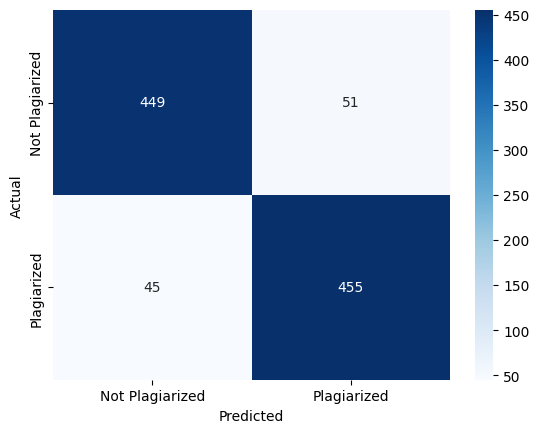

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

print("✅ Evaluating final model on test set...")
model.eval()
test_labels, test_scores = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)

        output1, output2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        scores = nn.CosineSimilarity(dim=1)(output1, output2).cpu().numpy()

        test_scores.extend(scores)
        test_labels.extend(batch['label'].cpu().numpy())

test_scores, test_labels = np.array(test_scores), np.array(test_labels)
test_preds = (test_scores > best_threshold).astype(int)

acc = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
auc = roc_auc_score(test_labels, test_scores)

print(f"\n🏆 Final Test Accuracy: {acc*100:.2f}%")
print(f"F1-score: {f1:.3f}, AUC: {auc:.3f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Not Plagiarized', 'Plagiarized']))

print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Plagiarized', 'Plagiarized'], yticklabels=['Not Plagiarized', 'Plagiarized'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
def check_plagiarism(code1, code2, model, tokenizer, threshold, device):
    model.eval()
    inputs1 = tokenizer(code1, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    inputs2 = tokenizer(code2, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        output1, output2 = model(inputs1.input_ids, inputs1.attention_mask, inputs2.input_ids, inputs2.attention_mask)
        distance = nn.CosineSimilarity(dim=1)(output1, output2).item()

    print(f"🔹 Similarity: {distance:.4f} | Threshold: {threshold:.4f}")
    if distance > threshold:
        print("✅ Verdict: Plagiarized\n")
    else:
        print("❌ Verdict: Not Plagiarized\n")

# Example 1 (Plagiarized)
code_a = """
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
"""

code_b = """
def calculate_factorial(num):
    if num == 0:
        return 1
    result = 1
    for i in range(1, num + 1):
        result *= i
    return result
"""

check_plagiarism(code_a, code_b, model, tokenizer, best_threshold, device)

# Example 2 (Not Plagiarized)
code_c = """
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr
"""

code_d = """
def is_palindrome(s):
    return s == s[::-1]
"""

check_plagiarism(code_c, code_d, model, tokenizer, best_threshold, device)


🔹 Similarity: 0.9980 | Threshold: 0.8800
✅ Verdict: Plagiarized

🔹 Similarity: 0.4024 | Threshold: 0.8800
❌ Verdict: Not Plagiarized




--- Graph 1: Similarity Score Distribution ---


/tmp/ipython-input-2918291974.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_scores[test_labels == 0], label='Not Plagiarized (Label 0)', shade=True)
/tmp/ipython-input-2918291974.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_scores[test_labels == 1], label='Plagiarized (Label 1)', shade=True)


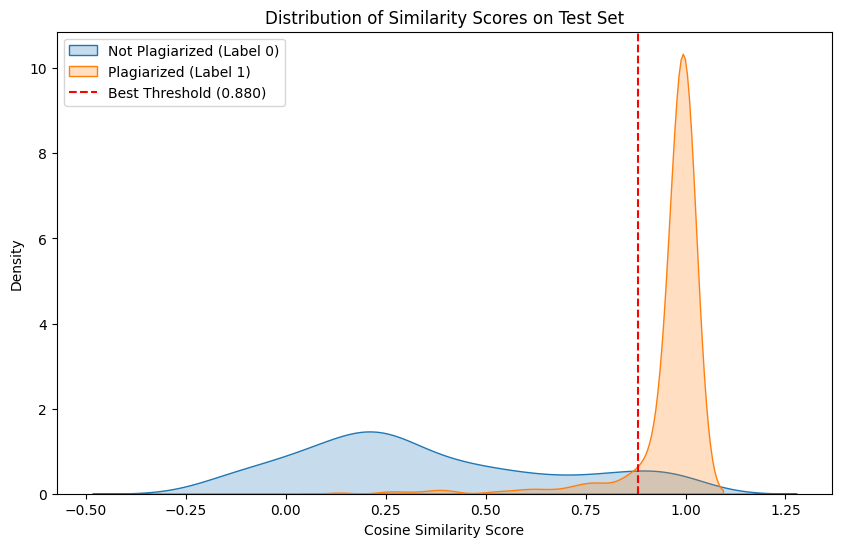


--- Graph 2: ROC Curve ---


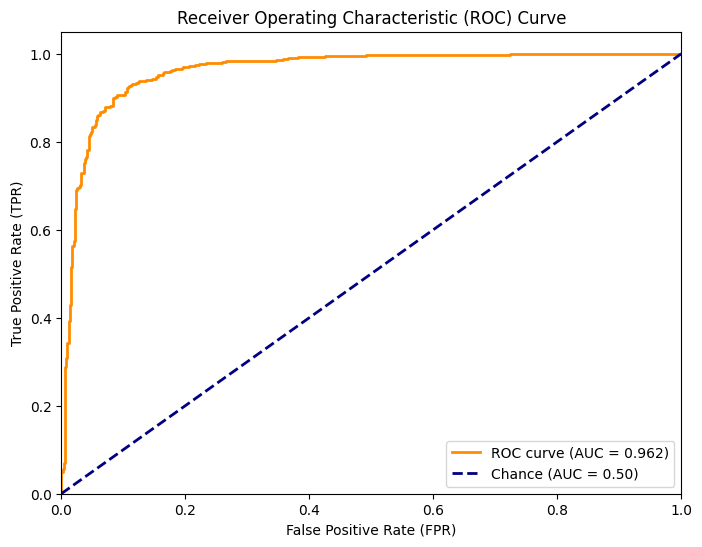


--- Graph 3: Confusion Matrix (from Step 6) ---


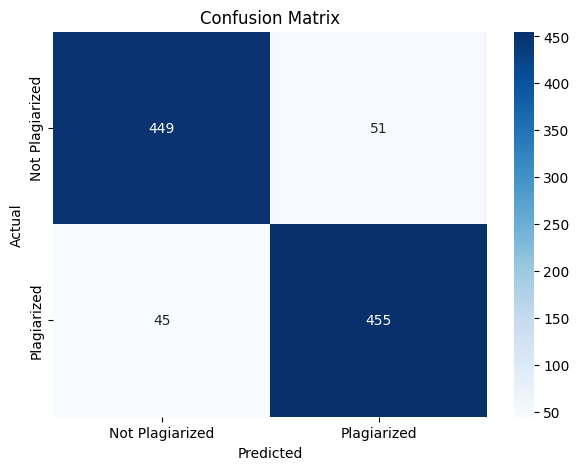

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Ensure you have run Step 6, so 'test_labels' and 'test_scores' exist.

# --- Graph 1: Similarity Score Distribution ---
# This is the most important graph to see the problem.

print("\n--- Graph 1: Similarity Score Distribution ---")
plt.figure(figsize=(10, 6))
sns.kdeplot(test_scores[test_labels == 0], label='Not Plagiarized (Label 0)', shade=True)
sns.kdeplot(test_scores[test_labels == 1], label='Plagiarized (Label 1)', shade=True)

# Plot the threshold you found
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold ({best_threshold:.3f})')
plt.title('Distribution of Similarity Scores on Test Set')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


# --- Graph 2: ROC Curve (Receiver Operating Characteristic) ---
# This shows the trade-off between True Positives and False Positives.

print("\n--- Graph 2: ROC Curve ---")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# --- Graph 3: Confusion Matrix ---
# Your Step 6 code already prints this, but here it is again for completeness.

print("\n--- Graph 3: Confusion Matrix (from Step 6) ---")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Plagiarized', 'Plagiarized'],
            yticklabels=['Not Plagiarized', 'Plagiarized'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save threshold to a NEW, SAFE file
with open(os.path.join(SAVE_DIRECTORY, 'inference_config.json'), 'w') as f:
    json.dump({"best_threshold": float(best_threshold)}, f, indent=4)